In [15]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

# Sc_sv N bEdges = {'ScN_VB':5.149753, 'ScN_CB':6.047881}
bEdges = {'ScN_VB':5.584459, 'ScN_CB':6.5}

DefTot = np.load('DefectTotalEnergyScN.npy').item()
E0 = DefTot['default'][0]['0']
FreyCorr = np.load('FreysoldtCorrectionsScN.npy').item()
ChemPot = np.load('ChemicalReferences.npy').item()
text_def = np.load('LineLabels.npy').item()
colors = np.load('LineColors.npy').item()

In [16]:
def setChemPot(cond, delta={}):
    mu = {}
    mu['Sc'] = cond[0] + ChemPot['Sc'][0]/ChemPot['Sc'][1]['Sc']
    mu['N'] = cond[1] + ChemPot['N'][0]/ChemPot['N'][1]['N']
    for ref in ChemPot:
        if len(set(ChemPot[ref][1].keys()) - {'Sc', 'N'}) > 1: 
            continue
        if len(ChemPot[ref][1]) == 1:
            for ele in ChemPot[ref][1]:
                if not ele in ['Sc', 'N']:
                    if not ele in mu: 
                        mu[ele] = 0
                    mu[ele] = min(mu[ele], ChemPot[ref][0] / ChemPot[ref][1][ele])
        else:
            for ele in ChemPot[ref][1]:
                if not ele in ['Sc', 'N']:
                    if not ele in mu: 
                        mu[ele] = 0
                    mu[ele] = min(mu[ele], ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
    return mu

In [17]:
def getPOSCARdiff(defect):
    default = {'Sc':32, 'N':32}
    n_mu = {}
    for i in DefTot[defect][1]:
        if i in default:
            n_mu[i] = DefTot[defect][1][i] - default[i]
        else: 
            n_mu[i] = DefTot[defect][1][i]
    return n_mu

In [18]:
def getLine(defect, cond, BandEdges = bEdges, Ef = np.arange(0, bEdges['ScN_CB']-bEdges['ScN_VB'],0.0001), charge = ''):
    chem = setChemPot(cond)
    defLoc = deepcopy(DefTot)
    defPar = defLoc[defect]
    n_mu = getPOSCARdiff(defect)
    levels = defPar[0]
    pLevels = {}
    #print levels
    #def_i_l = []
    
    if charge:
        if charge in FreyCorr[defect]:
            levels[charge] += FreyCorr[defect][charge]
        pLevels[charge] = defPar[0][charge] - E0 - sum(n_mu[j] * chem[j] for j in n_mu) + int(charge) * (Ef + BandEdges['ScN_VB'])
    else: 
        for i in levels:
            # add functionality to get defect levels: 
            # if str(int(i)-1) in levels:
            #    def_i_l += defPar[0][i] - defPar[0][str(int(i)-1)] - bEdges['VB']

            if i in FreyCorr[defect]:
                levels[i] += FreyCorr[defect][i]
            pLevels[i] = defPar[0][i] - E0 - sum(n_mu[j] * chem[j] for j in n_mu) + int(i) * (Ef + BandEdges['ScN_VB'])
    
    charges = [int(l) for l in pLevels]
    charges.sort()
    intlevels = {defect+' '+str(q)+'/'+str(q+1):round(pLevels[str(q)][0] - pLevels[str(q+1)][0],3) for q in charges[-len(charges):-1]}
    print intlevels
    pDefect = np.minimum.reduce([pLevels[i] for i in pLevels])
    #print (pDefect[0], pDefect[-1])
    return pDefect

In [19]:
from fractions import gcd
def FormEnth(Material):
    mat = ChemPot[Material]
    return (mat[0] - sum(ChemPot[ele][0]/ChemPot[ele][1][ele]* mat[1][ele] for ele in mat[1]))/reduce(gcd,[i for i in mat[1].values()])

In [20]:
Scpoor = [FormEnth('ScN'),  0]
Npoor = [0, FormEnth('ScN')]

In [25]:
def PlotForm(Defects, Condition, BandEdges=bEdges,ylimits=[]):
    fig = plt.figure()
    ax = plt.subplot(111)
    Ef = np.arange(0, BandEdges['ScN_CB']-BandEdges['ScN_VB'],0.0001)
    textx = 0.5
    for i in Defects:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        if Defects[i]:
            ax.text(Defects[i][0],Defects[i][1],text_def[i],fontdict={'size':18},color=colour)
        elif i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    if ylimits:
        plt.ylim(ylimits[0],ylimits[1])
    print(y)
    plt.xlim(0, BandEdges['ScN_CB']-BandEdges['ScN_VB'])
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.savefig('ScN_H.png', bbox_inches='tight', format='png', dpi=300)


In [26]:
FormEnth('ScN')

-4.091059514999998

{'H_i -1/0': 1.756, 'H_i 0/1': 1.471}
[-0.00372849 -0.00362849 -0.00352849 ...  0.91157151  0.91167151
  0.91177151]


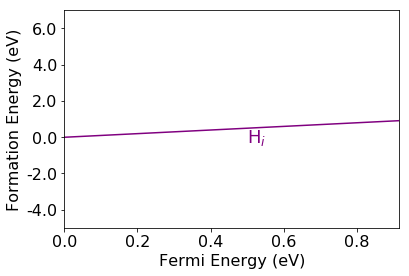

In [27]:
PlotForm({'H_i':[]},Scpoor,ylimits=[-5,7])


In [24]:
2.191 - 1.905


0.2859999999999998

In [11]:
0.2859999999999998 / 2 + 1.905

2.048

In [12]:
DefTot

{'H_i': [{'-1': -693.16900562, '0': -700.365323, '1': -707.61446714},
  {'H': 1, 'N': 32, 'Sc': 32}],
 'default': [{'0': -697.91974502}, {'N': 32, 'Sc': 32}]}

In [13]:
FreyCorr

{'H_i': {'-1': 0.144162, '1': 0.194162}, 'default': {}}

In [32]:
DefTot['H_i'][0]['0'] - DefTot['default'][0]['0']-ChemPot['H'][0]/2

1.466794650000061